In [1]:
import os
import pprint
import time

import numpy as np
import torch
from aml.plotting import TensorBoard, get_time,plot_to_image,bar_plot
import config
from SearchAlg.genetic_alg_general_functions import get_L, GetPhysicalLoss

from WinTermHelpers.query_helpers import *
from FileSystem.general_purpose_functions import *
from Alg.solving_algorithm import ModelGenerator
from FileSystem.storage import PStorage, SimResultsManager
from CustomModels.my_models import DistrMaker
from CustomModels.my_models import Integrator
import config
from general import plot_policy_function, plot_trajectories,get_sim_results,plot_policy_function_with_trajectories
from Simulation.sim_supp import make_psi, make_simulation_for_one_policy_function
import sys
from general_purpose_functions import time_mesuament
from inc_random_descent import insert_noise_to_p
import matplotlib.pyplot as plt
from config import theta_v_range, omega_v_range, F_v_range
from tqdm import tqdm
from numba import jit
from aml.plotting import *
import copy

from general import plot_rect
from matplotlib import cm

def WMA(arr_):
    N = len(arr_)
    weights = np.arange(start=1, stop=N+1, step=1)
    weights = 2/(N*(N+1))*weights
    return np.ma.average(a=arr_, weights=weights)

def SMA(arr_):
    N = len(arr_)
    weights = np.ones(shape=(N,))
    weights = 1/N*weights
    return np.ma.average(a=arr_, weights=weights)


def get_averaged_arr(arr_, window_size):
    N = len(arr_)
    av_arr_ = np.zeros(shape=(N,))
    for i in range(N):
        if i+1 < window_size:
            av_arr_[i] = WMA(arr_[:i + 1])
        else:
            av_arr_[i] = WMA(arr_[(i + 1) - window_size:i + 1])

    return av_arr_
def get_moving_std(arr_, arr_mean_, window_size):
    N = len(arr_)
    o_ = np.zeros(shape=(N,))
    delta = np.square(arr_ - arr_mean_)

    for i in range(N):
        if i+1 < window_size:
            o_[i] = np.sqrt(1/(window_size)*np.sum(delta[:i + 1]))
        else:
            o_[i] = np.sqrt(1/(window_size)*np.sum(delta[(i + 1) - window_size:i + 1]))
    return o_

def get_prediction_at_last_i(arr_, i, x_,window_size):
    o_ = -99999
    if i+1 < window_size:
        data_ = arr_[:i + 1]
        x_data =  x_[:i + 1]
        [b,a] = coefficient_reg_stat(x_data,data_)
        # print([b,a])
        if a  == 0 :
            return -1
        o_ = -b/a
    else:
        data_ = arr_[(i + 1) - window_size:i + 1]
        x_data = x_[(i + 1) - window_size:i + 1]
        [b,a] = coefficient_reg_stat(x_data,data_)
        if a == 0:
            return -1
        o_ = -b/a
    return int(o_)

def plot_random_policy(func, x1grid,x2grid):
    fig,ax = plt.subplots()
    fig.set_size_inches(16,9)
    
    x = []
    y = []
    rects_info = []
    highs = []
    num_of_points_in_plot = 0
    # в этом случае передали surf
    for i in range(len(x1grid)-1):
        for j in range(len(x2grid)-1):
            x_1 = x1grid[i]
            x_2 = x1grid[i+1]
            y_1 = x2grid[j]
            y_2 = x2grid[j+1]
            x.append((x_2 + x_1) / 2)
            y.append((y_2 + y_1) / 2)
            rects_info.append([x_1, x_2, y_1, y_2])
            expectation = np.mean([func((x_2 + x_1) / 2, (y_2 + y_1) / 2) for k in range(100)])
            highs.append(expectation)
            num_of_points_in_plot += 1
    norm = matplotlib.colors.Normalize(vmin=min(highs), vmax=max(highs))
    m = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    tmp_len = len(rects_info)
    for i in range(len(rects_info)):
        print("\r interation {} of {}".format(i, tmp_len), end='')
        plot_rect(ax, rects_info[i][0], rects_info[i][1], rects_info[i][2], rects_info[i][3],
                    m.to_rgba(highs[i]))

    plt.colorbar(m, ax=ax)
    ax.set_xlim([-1.0, 1.0])
    ax.set_ylim([-1.0, 1.0])
    ax.set_xlabel(r"$\theta, \: V$")
    ax.set_ylabel(r'$\omega, \: V$')
    ax.set_title(r'$F, \: V $')
    return fig,ax

def plot_trajectories_at_axis(ax, trajectories,colors,alpha):
    for i in range(len(trajectories)):
        tr = trajectories[i]
        th = tr[:,0]
        omega = tr[:,1]
        ax.plot(th,omega,c=colors[i],alpha=alpha[i])
    return ax


@jit(nopython=True)
def search_position_on_grid(grid:np.array,value:float)->int:
    # return segment index to which balue belongs
    N = len(grid)
    for i in range(N-1):
        if value >= grid[i] and value <= grid[i+1]:
            return i


def make_psi_from_policy_matrix(PI_,s1_grid,s2_grid,a1_values,N1,N2,M,translators_units_of_measurement,stat_decision='random'):

    if stat_decision == 'mean':
        def policy_func(x_1:float,x_2:float) -> float:
            # input [-1,1] \times [-1,1]
            # output [-1,1]
            k1 = search_position_on_grid(s1_grid,x_1)
            k2 = search_position_on_grid(s2_grid,x_2)
            i_ =  N2*k1 + k2
            # return np.random.choice(a1_values,p=PI_[i_])
            # return a1_values[np.argmax(PI_[i_])]
            return np.sum(a1_values*PI_[i_])
        return make_psi(policy_func,translators_units_of_measurement)    
    elif stat_decision == 'argmax':
        def policy_func(x_1:float,x_2:float) -> float:
            # input [-1,1] \times [-1,1]
            # output [-1,1]
            k1 = search_position_on_grid(s1_grid,x_1)
            k2 = search_position_on_grid(s2_grid,x_2)
            i_ =  N2*k1 + k2
            # return np.random.choice(a1_values,p=PI_[i_])
            return a1_values[np.argmax(PI_[i_])]
            # return np.sum(a1_values*PI_[i_])
        return make_psi(policy_func,translators_units_of_measurement)    
    elif stat_decision == 'random':
        def policy_func(x_1:float,x_2:float) -> float:
            # input [-1,1] \times [-1,1]
            # output [-1,1]
            k1 = search_position_on_grid(s1_grid,x_1)
            k2 = search_position_on_grid(s2_grid,x_2)
            i_ =  N2*k1 + k2
            return np.random.choice(a1_values,p=PI_[i_])
            # return a1_values[np.argmax(PI_[i_])]
            # return np.sum(a1_values*PI_[i_])
        return make_psi(policy_func,translators_units_of_measurement)    


def make_voltage_psi_from_policy_matrix(PI_,s1_grid,s2_grid,a1_values,N1,N2,M,stat_decision='random'):
    if stat_decision == 'mean':
        def policy_func(x_1:float,x_2:float) -> float:
            # input [-1,1] \times [-1,1]
            # output [-1,1]
            k1 = search_position_on_grid(s1_grid,x_1)
            k2 = search_position_on_grid(s2_grid,x_2)
            i_ =  N2*k1 + k2
            # return np.random.choice(a1_values,p=PI_[i_])
            # return a1_values[np.argmax(PI_[i_])]
            return np.sum(a1_values*PI_[i_])
        return policy_func
    elif stat_decision == 'argmax':
        def policy_func(x_1:float,x_2:float) -> float:
            # input [-1,1] \times [-1,1]
            # output [-1,1]
            k1 = search_position_on_grid(s1_grid,x_1)
            k2 = search_position_on_grid(s2_grid,x_2)
            i_ =  N2*k1 + k2
            # return np.random.choice(a1_values,p=PI_[i_])
            return a1_values[np.argmax(PI_[i_])]
            # return np.sum(a1_values*PI_[i_])
        return policy_func
    elif stat_decision == 'random':
        def policy_func(x_1:float,x_2:float) -> float:
            # input [-1,1] \times [-1,1]
            # output [-1,1]
            k1 = search_position_on_grid(s1_grid,x_1)
            k2 = search_position_on_grid(s2_grid,x_2)
            i_ =  N2*k1 + k2
            return np.random.choice(a1_values,p=PI_[i_])
            # return a1_values[np.argmax(PI_[i_])]
            # return np.sum(a1_values*PI_[i_])
        return policy_func





@jit(nopython = True)
def make_init_PI(N1,N2,M):
    # PI = np.ones(shape=(N1*N2,M),dtype=np.float32)/M
    PI = np.ones(shape=(N1*N2,M),dtype=np.float32)/M
    # for i in range(N1*N2):
        # PI[i] = np.random.uniform(low=0.001,high=1.0,size=M)
        # PI[i] = PI[i]/np.sum(PI[i]) 
    return PI

@jit(nopython = True)
def make_new_PI(old_PI:np.array,lambda_:float,alpha_:float,
                 N1:int,N2:int,M:int,s1_grid:np.array,
                 s2_grid:np.array, a1_grid:np.array,
                 tr:np.array, ac:np.array)->np.array:
    # PI = np.ones(shape=(N1*N2,M),dtype=np.float32)/M
    # PI = np.ones(shape=(N1*N2,M),dtype=np.float32)/M
    PI = np.copy(old_PI)
    # for i in range(N1*N2):
        # PI[i] = np.random.uniform(low=0.001,high=1.0,size=M)
        # PI[i] = PI[i]/np.sum(PI[i]) 

    # n_of_empty_states=  0
    for i in range(N1*N2):
        k1 = i // N2
        k2 = i - N2*k1
        p1_vec = np.zeros(shape=(M,),dtype=np.intc)
        p2_vec = np.zeros(shape=(M,),dtype=np.intc)
        for j in range(M):
            # count action[j] values and state[i] in elite trajectories
            p1 = 0
            p2 = 0
            for t in range(len(tr)):
                th = tr[t][0]
                omega = tr[t][1]
                a = ac[t]
                # state_hit = (th >= s1_grid[k1] and th <= s1_grid[k1+1]) and (omega >= s2_grid[k2] and omega <= s2_grid[k2+1])
                # action_hit = (a>=a1_grid[j] and a <= a1_grid[j+1])
                # if state_hit and action_hit:
                #     p1 +=1 
                # if state_hit:
                #     p2 += 1            
                state_hit = int((th >= s1_grid[k1] and th <= s1_grid[k1+1]) and (omega >= s2_grid[k2] and omega <= s2_grid[k2+1]))
                action_hit = int((a>=a1_grid[j] and a <= a1_grid[j+1]))
                p1 += state_hit*action_hit 
                p2 += state_hit
            p1_vec[j] = p1
            p2_vec[j] = p2
        # fig_i, ax_i = plot_float_distribution(p1_vec,fig_size=(5,5),title=str(i))
        # if np.sum(p1_vec) == 0:
        #     print('empty states')
        #     raise SystemExit

        # 0
        # if np.sum(p1_vec) != 0:
        #     PI[i] = p1_vec
        #     PI[i] = PI[i]/np.sum(PI[i])

        
        # 1
        # PI[i] = (p1_vec+lambda_)/(p2_vec+lambda_*M)
        # PI[i] = PI[i]/np.sum(PI[i])

        # 2
        where_p1_zero = p1_vec == 0
        num_of_zeros = np.sum(where_p1_zero)
        if num_of_zeros == 0:
            PI[i] = p1_vec/p2_vec
            PI[i] = PI[i]/np.sum(PI[i])
        elif num_of_zeros != M:
            where_p1_not_zero = p1_vec != 0
            PI[i][where_p1_not_zero] = p1_vec[where_p1_not_zero]/p2_vec[where_p1_not_zero]
            PI[i][where_p1_not_zero] = (1-alpha_)*PI[i][where_p1_not_zero]/np.sum(PI[i][where_p1_not_zero])
            PI[i][where_p1_zero] = alpha_ /np.sum(where_p1_zero)

        # 3
        # where_p1_not_zero = p1_vec != 0
        # PI[i][where_p1_not_zero] = p1_vec[where_p1_not_zero]/p2_vec[where_p1_not_zero]
        # PI[i][where_p1_not_zero] = (1-alpha_)*PI[i][where_p1_not_zero]/np.sum(PI[i][where_p1_not_zero])
        # PI[i][where_p1_zero] = alpha_ /np.sum(where_p1_zero)

    # raise SystemExit    
    return PI


@jit(nopython = True)
def get_index_of_state_by_state(s1_grid,s2_grid,N1,N2,x_1,x_2)->int:
    k1 = search_position_on_grid(s1_grid,x_1)
    k2 = search_position_on_grid(s2_grid,x_2)
    return N2*k1 + k2
    
def get_distance_from_degeneration(PI_old, PI_new, N, M, epsilon):
    # diff_ = np.linalg.norm(PI_new-PI_old)
    diff_ = np.sum(np.absolute(PI_old - PI_new))
    return diff_ - epsilon*N*M
    # diff_ = np.max(np.absolute(PI_old-PI_new))
    # return diff_ - epsilon

def coefficient_reg_stat(x, y):
    size = len(x)
    avg_x = sum(x)/len(x) # оценка МО величины x
    avg_y = sum(y)/len(y) # оценка МО величины y
    # оценка МО величины x*y
    avg_xy = sum(x[i]*y[i] for i in range(0,size))/size
    # оценка СКО величины x 
    std_x = (sum((x[i] - avg_x)**2 for i in range(0,size))/size)**0.5
    # оценка СКО величины y
    std_y = (sum((y[i] - avg_y)**2 for i in range(0,size))/size)**0.5
    # оценка коэффициента корреляции величин x и y
    corr_xy = (avg_xy - avg_x*avg_y)/(std_x*std_y)
    
    # расчет искомых коэффициентов
    w1 = corr_xy*std_y/std_x
    w0 = avg_y - avg_x*w1
    return w0, w1
def predict_linear(a,b,x):
    return a*x+b


@jit(nopython = True)
def L(solution:np.array,rho_max:float,gamma:float,tau:float,t_end:float)->float:
    theta_vec = solution[:,0]
    omega_vec = solution[:,1]
    T_ = len(theta_vec)
    rho_i = np.sqrt(np.square(theta_vec) + np.square(omega_vec))
    # theta_i = np.absolute(theta_vec)
    # delta_rho_i = np.diff(rho_i)
    # delta_theta_i = -np.diff(np.absolute(theta_vec))
    # delta_omega_i = -np.diff(np.absolute(omega_vec))
    r_vec = np.zeros(shape=(T_-1,),dtype=np.float32)
    for t in range(1, T_):
        r_vec[t-1] = 1/(rho_i[t]*np.absolute(t*tau/t_end)+0.001)
        # r_vec[t-1] = -rho_i[t]*np.absolute(t*tau/t_end)
        # r_vec[t-1] = -theta_i[t]*np.absolute(t*tau/t_end)/T_
        # r_vec[t-1]  = (theta_i[t-1] - theta_i[t])
    # r_vec =  r_vec*(1.0/T_)
    r_vec =  r_vec*T_
    # r_vec = r_vec * (1.0/theta_i[0]) 
    # simple_plot(np.arange(0,T_),rho_i,title=r'$\rho$',size=(5,5))
    # fig,ax = simple_plot(np.arange(1,T_),-r_vec,title=r'$loss$',size=(5,5))
    # ax.set_xlim(0,T_-1)
    # # simple_plot(np.arange(1,T_),delta_rho_i,title=r'$\delta_{rho}$',size=(5,5))
    # # plot_float_distribution(r_vec)
    # raise SystemExit
    return -r_vec

In [2]:
# exp_metadata = get_time()
board = TensorBoard(tensorboard_exe_path=config.tensorboard_path,
                    logdir=os.path.join(config.task_dir, 'tblog'),
                    port= '64001')
exp_metadata = 'final_result_m_5'+get_time()
board.InitExperiment(experiment_metadata= exp_metadata)

tensorboard http://localhost:64001/


hyperparameters

In [3]:
N1 = 10
N2 = 10
M = 10
lambda_ = 0.01
alpha_0 = 0.0
epsilon_ = 0.8
gamma_ = 0.99
N_ = 2000
num_of_iterations = 50
num_of_explorations = 20
stat_decision = 'random'
rho_max_ = np.sqrt(config.fuzzy_inf_params['th_max']**2 + config.fuzzy_inf_params['omega_max']**2)

discretize the values of continuous quantities $theta, omega, F$

In [4]:
s1_step = (theta_v_range[1]-theta_v_range[0])/N1 
s2_step = (omega_v_range[1]-omega_v_range[0])/N2
a1_step = (F_v_range[1]-F_v_range[0])/M

s1_grid = np.linspace(start=theta_v_range[0],stop=theta_v_range[1],num = N1+1)
s2_grid = np.linspace(start=omega_v_range[0],stop=omega_v_range[1],num = N2+1)
a1_grid = np.linspace(start=F_v_range[0],stop=F_v_range[1],num = M+1)
s1_grid_si = np.array([config.translators_units_of_measurement['from_th_in_volt_to_th_in_si'](el) for el in s1_grid],dtype=np.float32)
s2_grid_si = np.array([config.translators_units_of_measurement['from_omega_in_volt_to_omega_in_si'](el) for el in s2_grid],dtype=np.float32)
a1_grid_si = np.array([config.translators_units_of_measurement['from_v_in_volt_to_v_in_si'](el) for el in a1_grid],dtype=np.float32)
s1_values = np.arange(start = theta_v_range[0]+s1_step/2,stop=theta_v_range[1],step= s1_step)
s2_values = np.arange(start = omega_v_range[0]+s2_step/2,stop=omega_v_range[1],step= s2_step)
a1_values = np.arange(start = F_v_range[0]+a1_step/2,stop=F_v_range[1],step= a1_step)

set initial policy matrix

In [5]:
# PI = make_init_PI(N1,N2,M)
PI = torch.load(os.path.join(config.task_dir,'policy_ml.txt'))

make start points set

In [6]:
S_0 = []
for i in range(N1):
    for j in range(N2):
        S_0.append((s1_values[i],s2_values[j]))

main loop

In [7]:
policy_loss_vec = []
current_best_loss = 999999
current_best_PI = np.copy(PI)
all_states_indexes_list = np.arange(0,len(S_0))
# deg_vs = np.zeros(shape=(num_of_iterations,),dtype=np.float32)
dists_to_deg = []
current_iter_for_deg_compute = []
expectation_of_total_loss_per_start_state = {i:0.0 for i in all_states_indexes_list}
distribution_of_start_states = np.ones(shape=(N1*N2,), dtype = np.float32)/(N1*N2)
n = 0 
# for n in range(num_of_iterations):
number_of_completed_explorations = -1
while True:
# for n in range(num_of_iterations):
    # print('iteration {}/{}'.format(n+1,num_of_iterations))
    # sample trajectories
    psi = make_psi_from_policy_matrix(PI, s1_grid,s2_grid,a1_values,N1,N2,M,config.translators_units_of_measurement,stat_decision=stat_decision)

    condition_of_break = np.asarray([
        config.theta_range,
        config.omega_range,
        [-9999.0, 9999.0],
        [-9999.0, 9999.0]
    ])
    simulation = make_simulation_for_one_policy_function(
        psi=psi,
        phys_sim_params=config.phys_sim_params,
        condition_of_break=condition_of_break,
        object_params=config.phys_params,
        use_an_early_stop=False,
        action_check=False
        
    )
    # T = config.phys_sim_params['t_end']
    T = 2.0
    tau = config.phys_sim_params['tau']
    y_0 = config.phys_sim_params['y_0']
    v_0 = config.phys_sim_params['v_0']

    from_th_in_volt_to_th_in_si = config.translators_units_of_measurement['from_th_in_volt_to_th_in_si']
    from_omega_in_volt_to_omega_in_si = config.translators_units_of_measurement['from_omega_in_volt_to_omega_in_si']
    trajectories = []
    actions = []
    L_vec = np.zeros(shape=(N1*N2+N_,),dtype=np.float32)
    
    states_indexes = np.zeros(shape=(N1*N2+N_,),dtype=np.intc)
    Loss_per_pairs = []

    
    for i in range(N1*N2+N_):
        # get trajectory, get loss
        state_index = -1
        if i <= N1*N2-1:
            state_index = i
        else:
            # print(distribution_of_start_states)
            # print(np.sum(distribution_of_start_states))
            state_index = np.random.choice(all_states_indexes_list,p=distribution_of_start_states)
        states_indexes[i] = state_index
        s_0 = S_0[state_index]
        code_of_sim, solution, time_of_simulation, control_actions = simulation(
                                                                        from_th_in_volt_to_th_in_si(s_0[0]),
                                                                        from_omega_in_volt_to_omega_in_si(s_0[1]),
                                                                        y_0, v_0)
        solution = solution[:-1,:]
        control_actions = control_actions[1:]
        loss_for_pairs = L(solution,rho_max= rho_max_, gamma=gamma_,tau=tau,t_end=time_of_simulation)
        Loss_per_pairs.append(loss_for_pairs)
        # loss for pairs can be empty,bacause len(solution) can be 1. (zero state -> action -> out of bounds)
        L_vec[i] = np.sum(loss_for_pairs)
        # total_loss_per_start_state[state_index] = L_vec[i]
        trajectories.append(solution[:,:2])
        actions.append(control_actions)

    state_count = {i:0 for i in np.unique(states_indexes)}
    state_positions = {i:0 for i in np.unique(states_indexes)}
    trajectories_by_states = []
    for i in range(N1*N2+N_):
        state_count[states_indexes[i]]+=1
    for state_index in state_positions.keys():
        state_positions[state_index] = np.argwhere(states_indexes==state_index).flatten()
    
    Tr_elite = [] 
    A_elite = []

    if len(np.setdiff1d(all_states_indexes_list, list(state_positions.keys()))) !=0 :
           print('not all possible states in dataset')
           print('this states not in dataset')
           print(np.setdiff1d(all_states_indexes_list, list(state_positions.keys())))
           raise SystemExit
    for state_index in state_positions.keys():
        if state_count[state_index] == 0:
            print('state not in dataset. state index {}'.format(state_index))
            raise SystemExit
        if state_count[state_index] >= 1:
            state_trajectories = []
            state_losses = []
            state_actions = []
            # for state_pos in state_positions[state_index]:
            #     state_pos_ = state_pos[0]
            #     state_trajectories.append(trajectories[state_pos_])
            #     state_losses.append(L_vec[state_pos_])
            #     state_actions.append(actions[state_pos_])

            # # make elite trajectories like in pure cross entropy method
            # argsort_ = np.argsort(state_losses)
            # q = 0.1
            # num_ = np.maximum(1, int(q*len(state_trajectories)))
            # state_elite_tr = [state_trajectories[argsort_[j]] for j in range(num_)]
            # state_elite_actions = [state_actions[argsort_[j]] for j in range(num_)]
            # for i in range(len(state_elite_tr)):
            #     Tr_elite.append(state_elite_tr[i])
            #     A_elite.append(state_elite_actions[i])

            ## make elite pairs (s_{t-1},a_{t}}) -> (r_{t})
            ## dataset in form s_{i},a_{i} -> r_{i}
            elite_states = []
            elite_ations = []

            for state_pos_ in state_positions[state_index]:
                if len(Loss_per_pairs[state_pos_]) < 2 :
                    continue
                state_trajectories.append(trajectories[state_pos_])
                state_losses.append(Loss_per_pairs[state_pos_])
                state_actions.append(actions[state_pos_])
            if len(state_trajectories) == 0:
                continue
            all_state_losses = []
            for i in range(len(state_trajectories)):
                losses_= state_losses[i]
                for j in range(len(losses_)):
                    all_state_losses.append(losses_[j])
            expectation_of_total_loss_per_start_state[state_index] = np.mean(all_state_losses)




            best_states_indexes = []
            # get q-th percentile by losses (ascending order) 
            for i in range(len(state_trajectories)):
                tr_ = state_trajectories[i]
                ac_ = state_actions[i]
                losses_= state_losses[i]
                argsort_ = np.argsort(losses_)
                q = 0.1
                num_ = np.maximum(1, int(len(tr_)*q))
                # print(num_)
                best_pairs_states = [tr_[argsort_[j]] for j in range(num_)]
                best_pairs_actions = [ac_[argsort_[j]] for j in range(num_)]
                for j in range(len(best_pairs_states)):
                    elite_states.append(best_pairs_states[j])
                    elite_ations.append(best_pairs_actions[j])
                    state_index_at_j_step = get_index_of_state_by_state(s1_grid_si,s2_grid_si,N1,N2,best_pairs_states[j][0],best_pairs_states[j][1])
                    best_states_indexes.append(state_index_at_j_step)

            # # get all with positive reward 
            # for i in range(len(state_trajectories)):
            #     tr_ = state_trajectories[i]
            #     ac_ = state_actions[i]
            #     losses_= state_losses[i]
            #     argsort_ = np.argwhere(losses_ < 0.0).flatten()
            #     best_pairs_states = [tr_[argsort_[j]] for j in range(len(argsort_))]
            #     best_pairs_actions = [ac_[argsort_[j]] for j in range(len(argsort_))]
            #     for j in range(len(best_pairs_states)):
            #         elite_states.append(best_pairs_states[j])
            #         elite_ations.append(best_pairs_actions[j])
            #         state_index_at_j_step = get_index_of_state_by_state(s1_grid_si,s2_grid_si,N1,N2,best_pairs_states[j][0],best_pairs_states[j][1])
            #         best_states_indexes.append(state_index_at_j_step)


            # get pairs wich better then another (s,a) pairs but the states \set{s} of these pairs is not in the list of all possible states  
            # (coverage of all states is not complete)        
            # state_inex is index of initial state
            unique_best_states_indexes = np.unique(best_states_indexes)
            all_states_indexes_in_tr = []
            unseen_losses = []
            unseen_tr = []
            unseen_ac = [] 
            unseen_states = []
            for i in range(len(state_trajectories)):
                tr_ = state_trajectories[i]
                ac_ = state_actions[i]
                losses_= state_losses[i]
                for j in range(len(tr_)-1):
                    state_index_at_j_step = get_index_of_state_by_state(s1_grid_si,s2_grid_si,N1,N2,tr_[j][0],tr_[j][1])
                    all_states_indexes_in_tr.append(state_index_at_j_step)
                    if state_index_at_j_step not in unique_best_states_indexes:
                        unseen_losses.append(losses_[j])
                        unseen_tr.append(tr_[j])
                        unseen_ac.append(ac_[j])
                        unseen_states.append(state_index_at_j_step)

            unseen_losses = np.array(unseen_losses,dtype=np.float32)
            unseen_tr = np.array(unseen_tr,dtype=np.float32)
            unseen_ac = np.array(unseen_ac,dtype=np.float32)
            unseen_states = np.array(unseen_states,dtype=np.intc)
            # print(len(unseen_states))
            # print(np.unique(unseen_states))
            # raise SystemExit
            unchoosen_states_in_trajectory = np.unique(unseen_states)
            for unselected_state in unchoosen_states_in_trajectory:
                where_state = np.argwhere(unseen_states == unselected_state).flatten()
                st_ls = unseen_losses[where_state]
                st_ac = unseen_ac[where_state]
                st_tr = unseen_tr[where_state]
                argsort_ = np.argsort(st_ls)
                q = 0.1
                num_ = np.maximum(1, int(len(st_tr)*q))
                best_pairs_states = [st_tr[argsort_[j]] for j in range(num_)]
                best_pairs_actions = [st_ac[argsort_[j]] for j in range(num_)]
                # argsort_ = np.argwhere(st_ls < 0.0).flatten()
                # best_pairs_states = [st_tr[argsort_[j]] for j in range(len(argsort_))]
                # best_pairs_actions = [st_ac[argsort_[j]] for j in range(len(argsort_))]
                # if len(best_pairs_actions) ==1 :
                #     print(best_pairs_states)
                for j in range(len(best_pairs_states)):
                    elite_states.append(best_pairs_states[j])
                    elite_ations.append(best_pairs_actions[j])
                
            if len(elite_states) !=0:
                for j in range(len(elite_states)):
                    Tr_elite.append(elite_states[j])
                    A_elite.append(elite_ations[j])
            # print('unseen states:')
            # print(unchoosen_states_in_trajectory)
    
    # states_plot_ = expectation_of_total_loss_per_start_state.keys()
    # hights_ = [expectation_of_total_loss_per_start_state[el] for el in states_plot_]
    # bar_fig, bar_ax = bar_plot(objects=states_plot_, heights=hights_,fig_size=(16,9),title=r'$E\mathcal{L} (s_{0})$')
    # img_ = plot_to_image(bar_fig)
    # board.PlotImage(experiment_metadata=exp_metadata,img=img_,label='loss per state',step = n)
    Tr_elite = np.array(Tr_elite, dtype=np.float32)
    A_elite = np.array(A_elite,dtype=np.float32)
    #final check
    all_states_in_dataset = []
    for obs_ in Tr_elite:
        obs_index = get_index_of_state_by_state(s1_grid_si,s2_grid_si,N1,N2,obs_[0],obs_[1])
        all_states_in_dataset.append(obs_index)
    all_states_in_dataset= np.unique(all_states_in_dataset)
    if len(np.setdiff1d(all_states_indexes_list,all_states_in_dataset)) !=0 :
        print('not all possible states in dataset')
        print('this states not in dataset')
        print(np.setdiff1d(all_states_indexes_list,all_states_in_dataset))
        print('this states in dataset')
        print(all_states_in_dataset)
        raise SystemExit

    p_loss_ = np.mean(L_vec)
    policy_loss_vec.append(p_loss_)
    # policy_loss_vec[n] = p_loss_

    if p_loss_ <= current_best_loss:
        current_best_PI = np.copy(PI)
        current_best_loss = p_loss_
    
    # if n==0:
    #     PI = PI_new 
    # else:
    # alpha_t = (1-(n+1)/(num_of_iterations-1))*alpha_0
    alpha_t = 0.0
    PI_new = make_new_PI(PI, lambda_,alpha_t,N1,N2,M,s1_grid_si,s2_grid_si,a1_grid_si,Tr_elite,A_elite)
    PI_new = (1-epsilon_)*PI_new + epsilon_*PI 
    dist_to_deg =  get_distance_from_degeneration(PI,PI_new,N1*N2,M,epsilon=0.001)
    

    # update distibution of start states
    
    losses_per_init_state = []
    init_states_ = []
    for init_state, loss_for_init_state in expectation_of_total_loss_per_start_state.items():
        losses_per_init_state.append(loss_for_init_state)
        init_states_.append(init_state)

    # plot current distr of init states 
    # bar_fig, bar_ax = bar_plot(objects=init_states_, heights=distribution_of_start_states,fig_size=(16,9),title=r'$p_{n}(s_{0})}$')
    # img_ = plot_to_image(bar_fig)
    # board.PlotImage(experiment_metadata=exp_metadata,img=img_,label='distr of init states',step = n)

    losses_per_init_state = np.array(losses_per_init_state,dtype=np.float32)
    init_states_ = np.array(init_states_,dtype=np.intc)
    # argsort_des = np.argsort(losses_per_init_state)[::-1]
    inverted_losses_ = losses_per_init_state - np.min(losses_per_init_state)
    inverted_losses_ = inverted_losses_
    # inverted_losses_ = np.max(inverted_losses_) - inverted_losses_
    # distr_ = 1.0/(inverted_losses_ + 0.001)
    distr_ = None
    if np.sum(inverted_losses_)==0.0:
        distr_ = np.ones(shape=(N1*N2,),dtype=np.float32)*(1.0/(N1*N2))
    else:
        distr_ = inverted_losses_/np.sum(inverted_losses_)
    distribution_of_start_states = distr_*(1-0.8)+distribution_of_start_states*0.8
    distribution_of_start_states = distribution_of_start_states/np.sum(distribution_of_start_states)


    # print(losses_per_init_state)
    # fig1,ax1 = bar_plot(init_states_, losses_per_init_state,fig_size=(16,9),title='computed losses')
    # fig2,ax2 = bar_plot(init_states_, inverted_losses_,fig_size=(16,9),title='inverted losses')
    # fig3,ax3 = bar_plot(init_states_, distr_,fig_size=(16,9),title='updated distr of init states')
    # ax1.set_yscale('log')
    # ax2.set_yscale('log')
    # plt.show()
    # raise SystemExit
    # distribution_of_start_states = 

    board.Push(experiment_metadata=exp_metadata,
               x=n,y=-p_loss_, label='total reward')
    board.Push(experiment_metadata=exp_metadata,
            x=n,y=dist_to_deg, label='dist to deg')
    if dist_to_deg <= 0:
        print('stop at {} iteration'.format(n))
        print('current loss {}'.format(p_loss_))
        print('best loss {}'.format(current_best_loss))
        number_of_completed_explorations += 1
        # mix with uniform actions to explore 
        PI_new = 0.5*PI+ 0.5*np.ones(shape=(N1*N2,M),dtype=np.float32)/M
        distribution_of_start_states = 0.5*distribution_of_start_states + 0.5*np.ones(shape=(N1*N2,),dtype=np.float32)/(N1*N2)
        distribution_of_start_states = distribution_of_start_states/np.sum(distribution_of_start_states)
        if number_of_completed_explorations >= num_of_explorations:
            break
    stop_at_predict = -1
    current_iter_for_deg_compute.append(n)
    dists_to_deg.append(dist_to_deg) 
    if n > 2:
        stop_at_predict = get_prediction_at_last_i(dists_to_deg, n, current_iter_for_deg_compute
                                                   ,window_size = 30)
        
    print('iteration {}. stop at {} iteration. deg dist {} \t loss {}'.format(
        n, stop_at_predict, str(dist_to_deg)[:6],str(p_loss_)))
   
    PI = PI_new
    n = n + 1

# PI = current_best_PI

iteration 0. stop at -1 iteration. deg dist 5.5686 	 loss -12934.094
iteration 1. stop at -1 iteration. deg dist 5.6325 	 loss -12137.075
iteration 2. stop at -1 iteration. deg dist 5.5483 	 loss -10866.103
iteration 3. stop at 97 iteration. deg dist 5.4035 	 loss -9742.99
iteration 4. stop at 83 iteration. deg dist 5.3456 	 loss -8900.17
iteration 5. stop at 128 iteration. deg dist 5.4651 	 loss -8333.918
iteration 6. stop at 338 iteration. deg dist 5.5947 	 loss -7187.517
iteration 7. stop at 98309 iteration. deg dist 5.6388 	 loss -6276.7993
iteration 8. stop at 7130 iteration. deg dist 5.5136 	 loss -6020.436
iteration 9. stop at 1789 iteration. deg dist 5.4771 	 loss -5103.826
iteration 10. stop at 251 iteration. deg dist 5.0800 	 loss -4910.548
iteration 11. stop at 525 iteration. deg dist 5.6496 	 loss -4158.625
iteration 12. stop at 637 iteration. deg dist 5.4811 	 loss -4543.9556
iteration 13. stop at 381 iteration. deg dist 5.2241 	 loss -3978.3381
iteration 14. stop at 457 i

KeyboardInterrupt: 

In [8]:
num_of_iterations = n+1

In [15]:
torch.save(PI,os.path.join(config.task_dir,'policy_ml.txt'))

In [10]:
# torch.save(PI,os.path.join(config.task_dir,'policy_ml_backup.txt'))

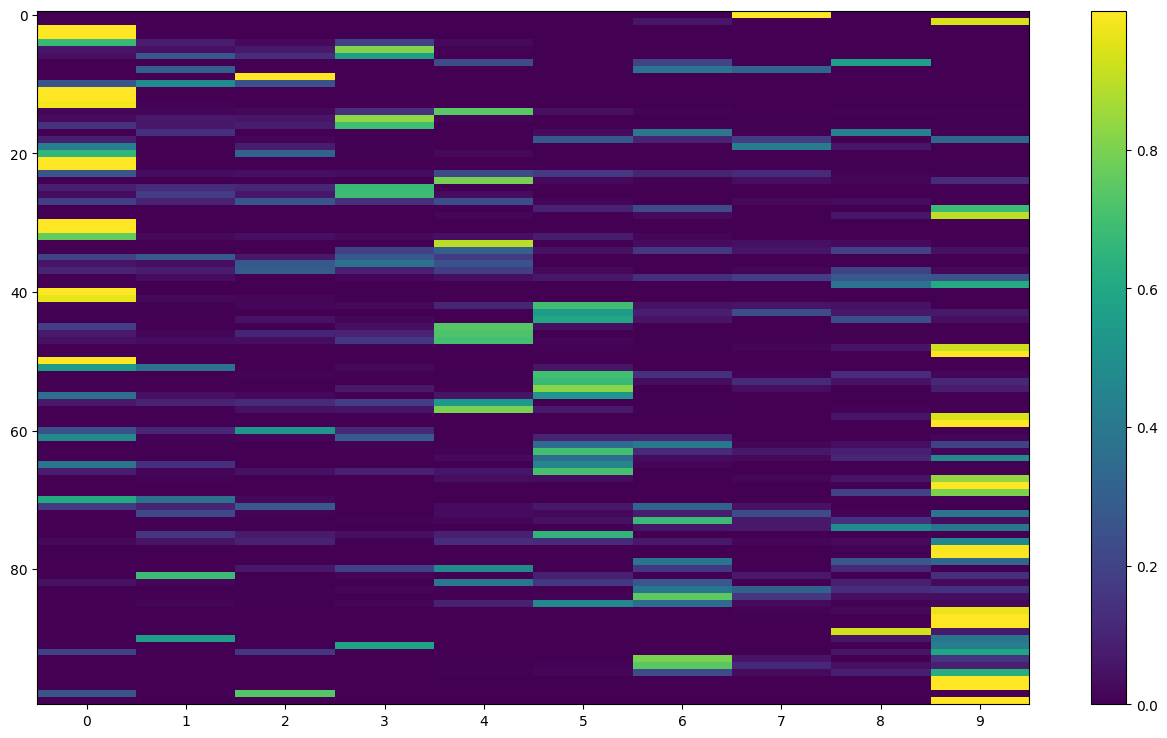

In [11]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(16,9)
im_ = ax1.imshow(PI)
fig1.colorbar(im_, ax=ax1)
ax1.set_xticks(np.arange(start=0,stop=len(a1_values)))
fig1.gca().set_aspect('auto')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1952,) and (1951,)

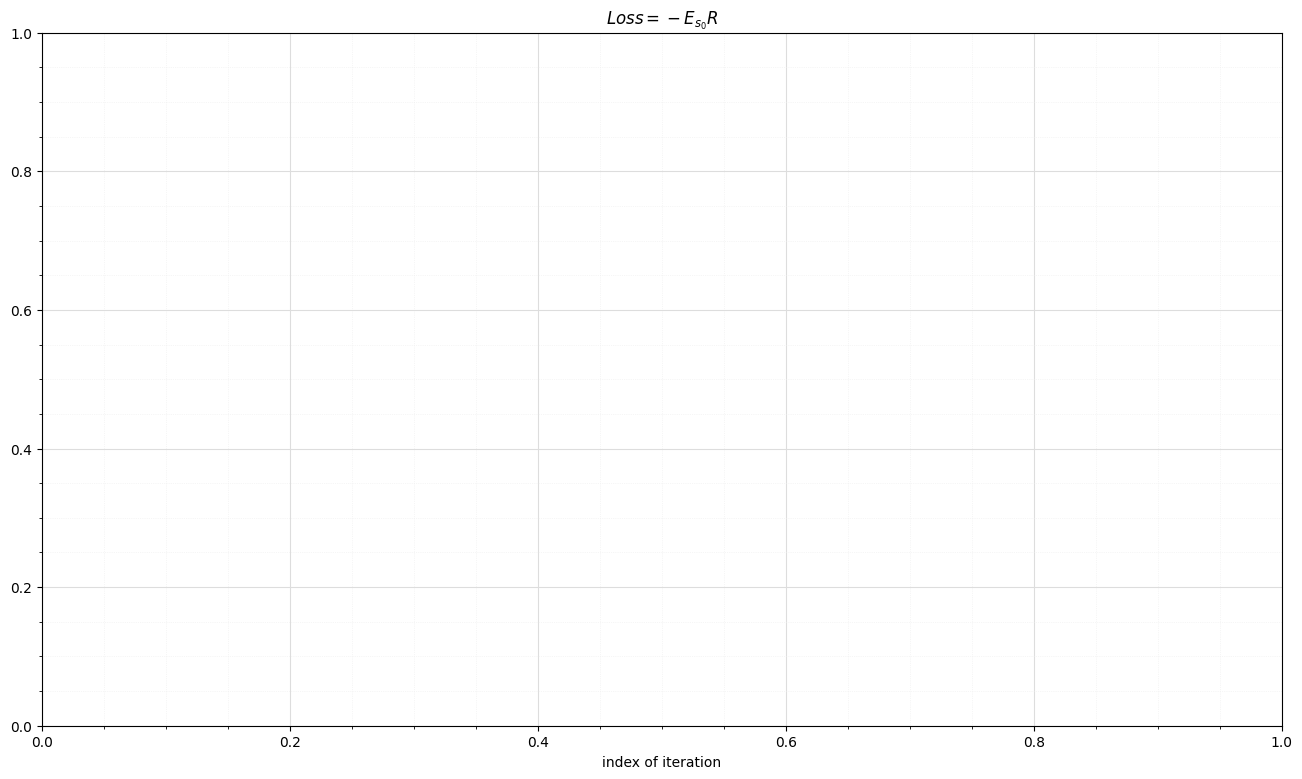

In [12]:
# fig,ax = simple_plot(np.arange(0,num_of_iterations),policy_loss_vec,title=r'$-E_{s_{0}}R$')
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
ax.grid()
ax.minorticks_on()
ax.set_title(r'$Loss = -E_{s_{0}}R$')
ax.set_xlabel('index of iteration')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
m_err = get_averaged_arr(policy_loss_vec[:num_of_iterations],window_size=50)
ax.plot(np.arange(0,num_of_iterations),m_err,'ko--', linewidth=2, markersize=6)
m_std = get_moving_std(policy_loss_vec[:num_of_iterations], m_err,window_size=50)
ax.fill_between(np.arange(0,num_of_iterations), m_err-m_std, m_err+m_std, color= '#eb86b1')

(<Figure size 1600x900 with 1 Axes>,
 <Axes: title={'center': 'distance to convergence'}>)

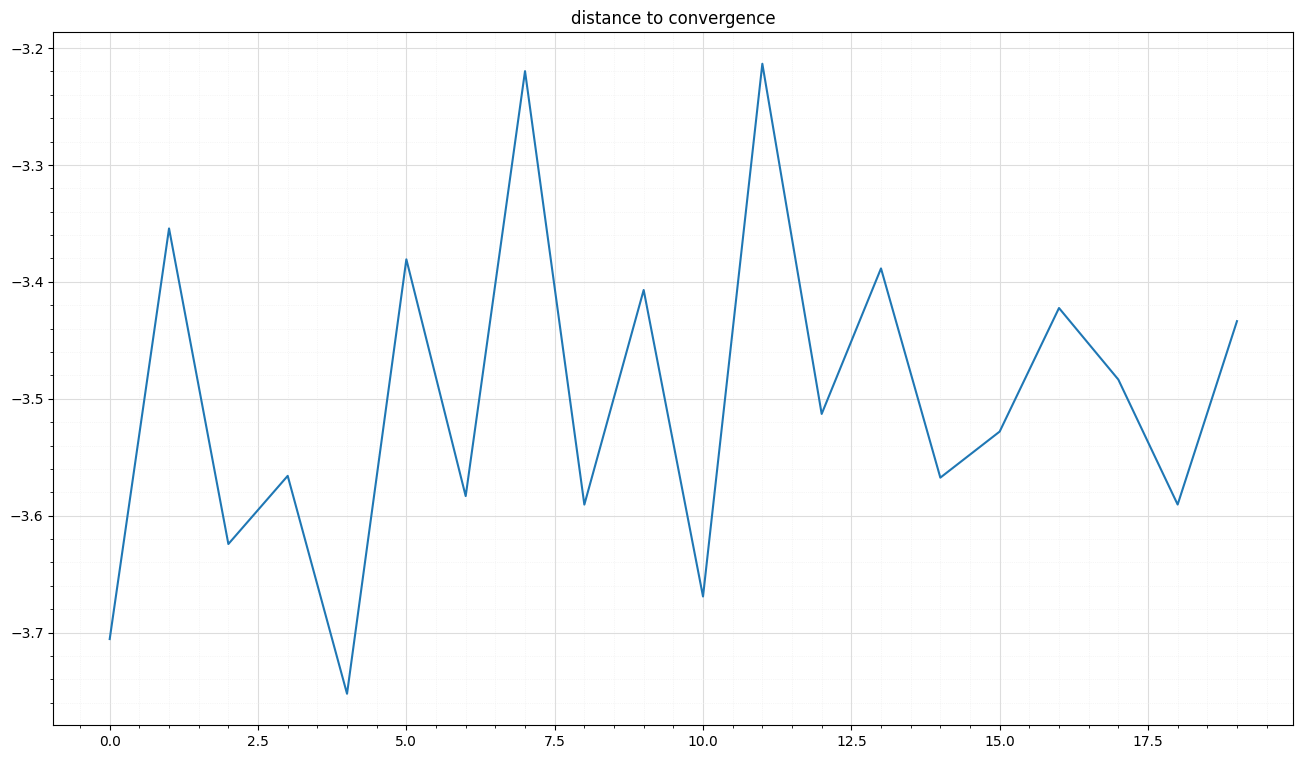

In [ ]:
simple_plot(x=np.arange(0,num_of_iterations-1),y=dists_to_deg,title='distance to convergence')

In [13]:
PI_ = torch.load(os.path.join(config.task_dir,'policy_ml.txt'))
# PI_ = PI
# PI = current_best_PI
# test_des = 'argmax'
test_des = 'random'
# test_des = 'mean'
psi_v = make_voltage_psi_from_policy_matrix(PI_, s1_grid,s2_grid,a1_values,N1,N2,M,stat_decision=test_des)
psi = make_psi_from_policy_matrix(PI_, s1_grid,s2_grid,a1_values,N1,N2,M,config.translators_units_of_measurement,stat_decision=test_des)

 interation 99 of 100
bad 56 good 44
 interation 99 of 100

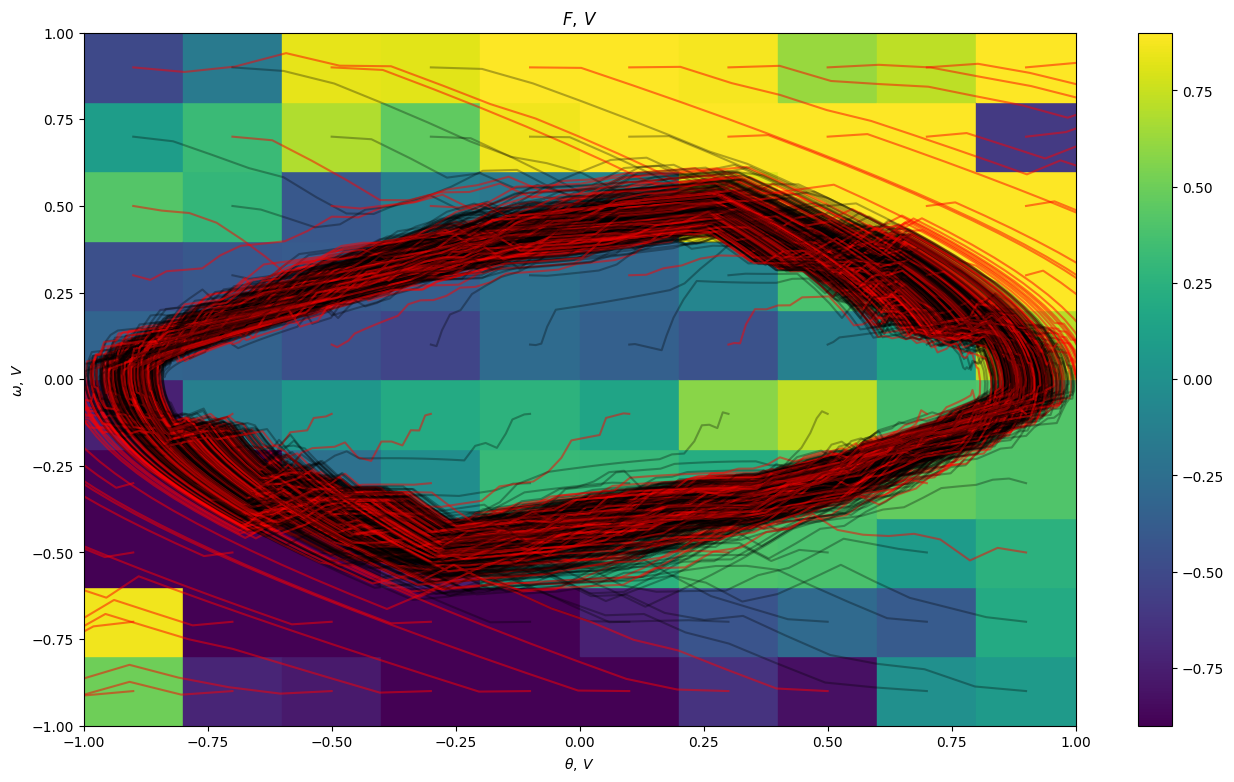

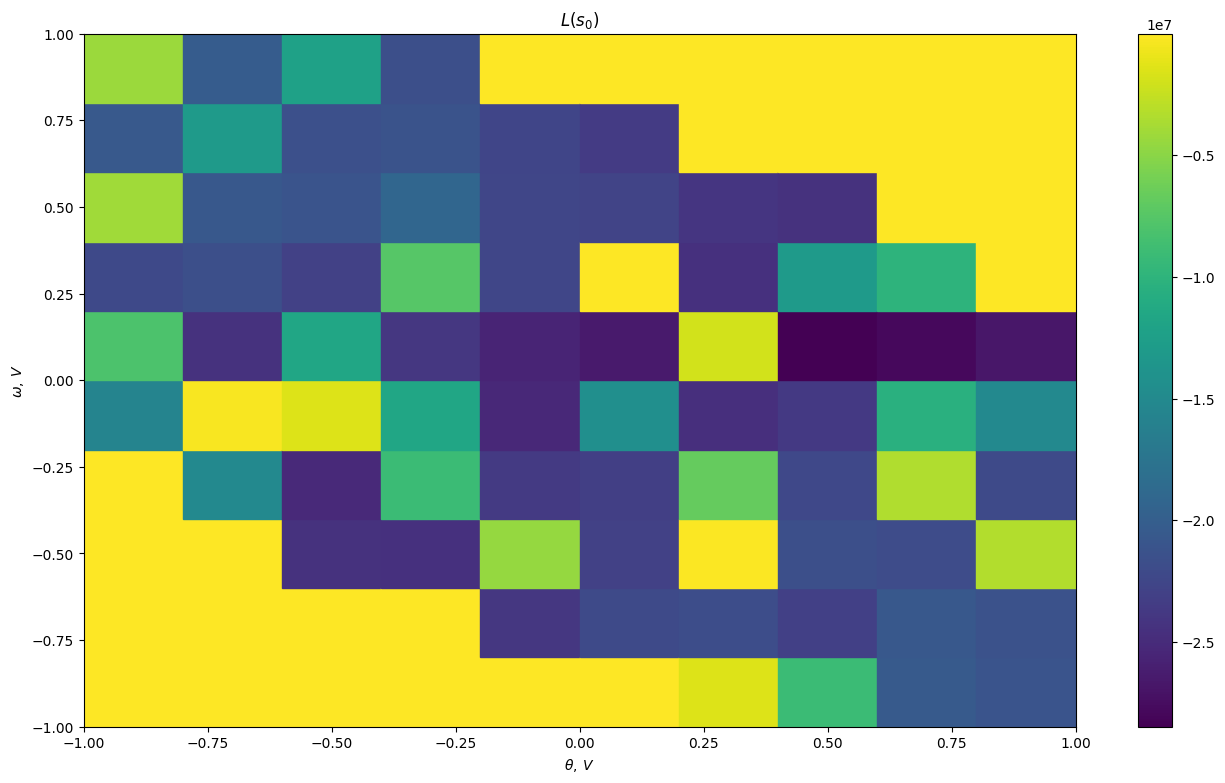

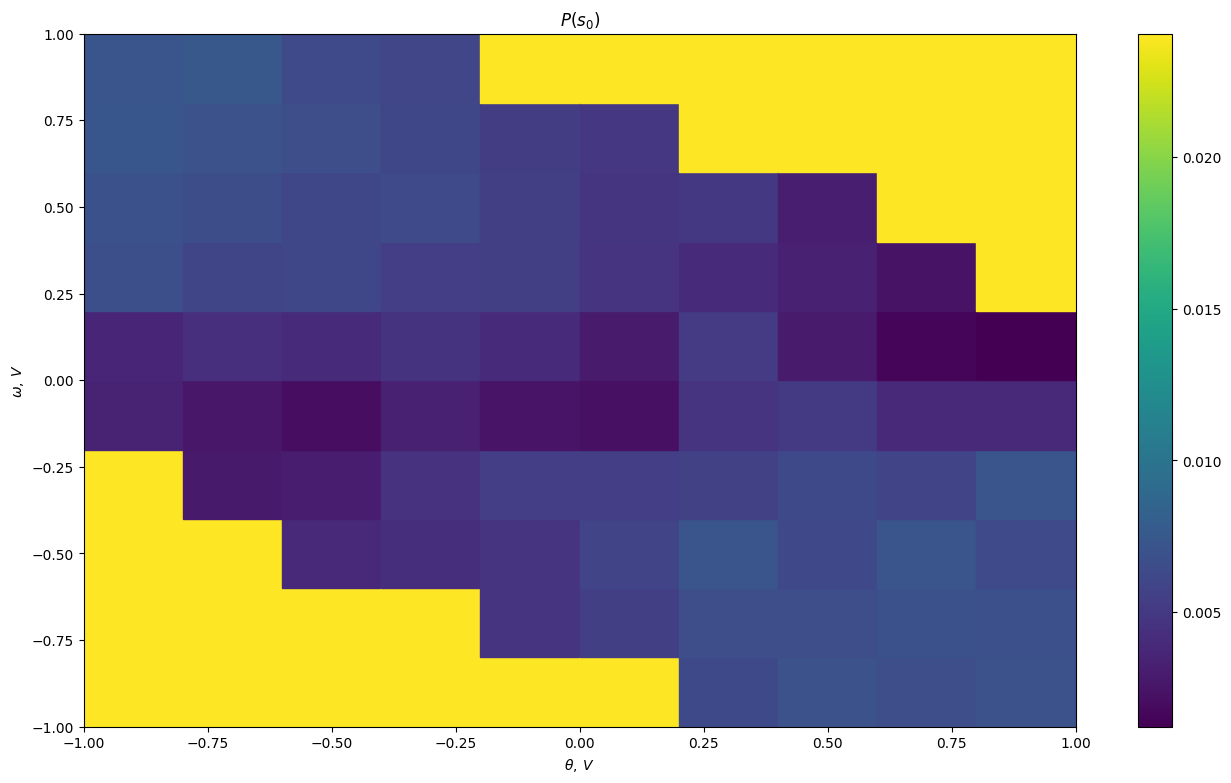

In [14]:
fig,ax= plot_random_policy(psi_v, s1_grid,s2_grid)
condition_of_break = np.asarray([
    config.theta_range,
    config.omega_range,
    [-9999.0, 9999.0],
    [-9999.0, 9999.0]
])
simulation = make_simulation_for_one_policy_function(
    psi=psi,
    phys_sim_params=config.phys_sim_params,
    condition_of_break=condition_of_break,
    object_params=config.phys_params,
    use_an_early_stop=False,
    action_check=False
    
)
T = config.phys_sim_params['t_end']
y_0 = config.phys_sim_params['y_0']
v_0 = config.phys_sim_params['v_0']

from_th_in_volt_to_th_in_si = config.translators_units_of_measurement['from_th_in_volt_to_th_in_si']
from_omega_in_volt_to_omega_in_si = config.translators_units_of_measurement['from_omega_in_volt_to_omega_in_si']
from_th_in_si_to_th_in_volt = config.translators_units_of_measurement['from_th_in_si_to_th_in_volt']
from_omega_in_si_to_omega_in_volt = config.translators_units_of_measurement['from_omega_in_si_to_omega_in_volt']
trajectories = []
colors = []
alphas = []
n_bad = 0
n_good = 0
L_vec_ = np.zeros(shape=(len(S_0),),dtype=np.float32)
for i in range(len(S_0)):
    # get trajectory, get loss
    s_0 = S_0[i]
    code_of_sim, solution, time_of_simulation, control_actions = simulation(
                                                                    from_th_in_volt_to_th_in_si(s_0[0]),
                                                                    from_omega_in_volt_to_omega_in_si(s_0[1]),
                                                                    y_0, v_0)
    trajectories.append(solution[:,:2])
    actions.append(control_actions)
    loss_for_pairs = L(solution,rho_max= rho_max_, gamma=gamma_,tau=tau,t_end=time_of_simulation)
    # loss for pairs can be empty,bacause len(solution) can be 1. (zero state -> action -> out of bounds)
    L_vec_[i] = np.sum(loss_for_pairs)
    if code_of_sim == 1:
        colors.append('r')
        alphas.append(0.5)
        n_bad  +=1 
    else:
        colors.append('k')
        alphas.append(0.3)
        n_good +=1 
print('\nbad {} good {}'.format(n_bad, n_good))
trajectories_v = []
for tr in trajectories:
    tr_v = np.array([(from_th_in_si_to_th_in_volt(el[0]),from_omega_in_si_to_omega_in_volt(el[1])) for el in tr])
    trajectories_v.append(tr_v)
plot_trajectories_at_axis(ax,trajectories_v,colors,alphas)
def loss_function_(x_1,x_2):
    index_of_st_ = get_index_of_state_by_state(s1_grid,s2_grid,N1,N2,x_1=x_1,x_2=x_2)
    return L_vec_[index_of_st_]
fig2,ax2= plot_random_policy(loss_function_, s1_grid,s2_grid)
ax2.set_title(r'$L(s_{0})$')

def distr_of_init_states_function(x_1,x_2):
    index_of_st_ = get_index_of_state_by_state(s1_grid,s2_grid,N1,N2,x_1=x_1,x_2=x_2)
    return distribution_of_start_states[index_of_st_]
fig3,ax3= plot_random_policy(distr_of_init_states_function, s1_grid,s2_grid)
ax3.set_title(r'$P(s_{0})$')
plt.show()
img_ = plot_to_image(fig)
board.PlotImage(experiment_metadata=exp_metadata, img=img_, label='response surf')


In [ ]:

# policy_loss_vec = np.zeros(shape=(num_of_iterations,))
# last_best_loss = 99999
# for n in tqdm(range(num_of_iterations)):
#     # print('iteration {}/{}'.format(n+1,num_of_iterations))
#     # sample trajectories
#     psi = make_psi_from_policy_matrix(PI, s1_grid,s2_grid,a1_values,N1,N2,M,config.translators_units_of_measurement)

#     condition_of_break = np.asarray([
#         config.theta_range,
#         config.omega_range,
#         [-9999.0, 9999.0],
#         [-9999.0, 9999.0]
#     ])
#     simulation = make_simulation_for_one_policy_function(
#         psi=psi,
#         phys_sim_params=config.phys_sim_params,
#         condition_of_break=condition_of_break,
#         object_params=config.phys_params,
#         use_an_early_stop=False,
#         action_check=False
        
#     )
#     # T = config.phys_sim_params['t_end']
#     T = 3.0
#     tau = config.phys_sim_params['tau']
#     y_0 = config.phys_sim_params['y_0']
#     v_0 = config.phys_sim_params['v_0']

#     from_th_in_volt_to_th_in_si = config.translators_units_of_measurement['from_th_in_volt_to_th_in_si']
#     from_omega_in_volt_to_omega_in_si = config.translators_units_of_measurement['from_omega_in_volt_to_omega_in_si']
#     trajectories = []
#     actions = []
#     L_vec = np.zeros(shape=(N_,),dtype=np.float32)
#     current_best_loss = 999999
#     current_best_PI = PI
#     for i in range(N_):
#         # get trajectory, get loss
#         s_0 = S_0[np.random.randint(low=0,high=len(S_0))]
#         code_of_sim, solution, time_of_simulation, control_actions = simulation(
#                                                                         from_th_in_volt_to_th_in_si(s_0[0]),
#                                                                         from_omega_in_volt_to_omega_in_si(s_0[1]),
#                                                                         y_0, v_0)
#         solution = solution[:-1,:]
#         control_actions = control_actions[1:]
#         loss_for_pairs = L(solution,rho_max= rho_max_, gamma=gamma_,tau=tau,t_end=T)
#         L_vec[i] = np.sum(loss_for_pairs)
#         trajectories.append(solution)
#         actions.append(control_actions)

#         # solution = solution[:-1,:]
#         # control_actions = control_actions[1:]
#         # loss_for_pairs = L(solution,rho_max= rho_max_, gamma=gamma_,tau=tau,t_end=T)
#         # # good_pairs = loss_for_pairs <= 0.0
#         # argsrot_for_pairs = np.argsort(loss_for_pairs)
#         # fraction_of_objects = 0.1
#         # best_pairs_n = int(fraction_of_objects*len(loss_for_pairs))
#         # if best_pairs_n == 0:
#         #     continue
#         # best_solutions = np.array([solution[argsrot_for_pairs[k]] for k in range(best_pairs_n)])
#         # best_actions = np.array([control_actions[argsrot_for_pairs[k]] for k in range(best_pairs_n)])

#         # trajectories.append(best_solutions)
#         # actions.append(best_actions)
#         # L_vec[i] = np.mean(loss_for_pairs)



#     # #select elite trajectories
#     argsort_ = np.argsort(L_vec)
#     Tr_elite = [trajectories[argsort_[j]] for j in range(k_best)] 
#     A_elite = [actions[argsort_[j]] for j in range(k_best)]
#     #select elite trajectories
#     # Tr_elite = trajectories
#     # A_elite = actions

#     p_loss_ = np.mean(L_vec)
#     policy_loss_vec[n] = p_loss_

#     if p_loss_ <= current_best_loss:
#         current_best_PI = copy.deepcopy(PI)
#         current_best_loss = p_loss_
#     #update policy
#     PI_new = make_new_PI(lambda_,N1,N2,M,s1_grid,s2_grid,a1_grid,Tr_elite,A_elite)

#     PI = (1-epsilon_)*PI_new + epsilon_*PI

#     # print('policy loss {}'.format(p_loss_))


#     # if n ==0 :

#     #     #update policy
#     #     PI_new = make_new_PI(lambda_,N1,N2,M,s1_grid,s2_grid,a1_grid,Tr_elite,A_elite)
#     #     PI = (1-epsilon_)*PI_new + epsilon_*PI
#     #     last_best_loss = p_loss_
#     #     print('policy loss {}'.format(p_loss_))
#     # elif p_loss_ <= last_best_loss:
#     #     last_best_loss = p_loss_
#     #     #update policy
#     #     PI_new = make_new_PI(lambda_,N1,N2,M,s1_grid,s2_grid,a1_grid,Tr_elite,A_elite)

#     #     PI = (1-epsilon_)*PI_new + epsilon_*PI

#     #     print('policy loss {}'.format(p_loss_))
# PI = current_best_PI